# Fisher divergence: properties and comparisons

### Author: Mingtian Zhang

In [61]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Bernoulli,Normal,Categorical
import numpy as np
import operator
import itertools
import os
import matplotlib.pyplot as plt
from mog import MixtureSameFamily
import torch.autograd as autograd


### Data distribution: a mixture of two Gaussians

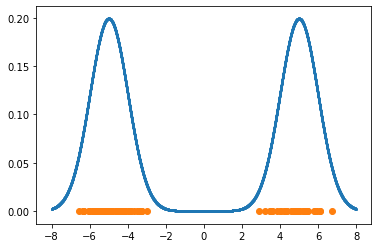

In [2]:
mix = Categorical(torch.ones(2))
comp = Normal(torch.tensor([-5.,5.,]), torch.tensor([1.,1.]))
gmm = MixtureSameFamily(mix, comp)

sample=gmm.sample([100])
x_grid=torch.linspace(-8,8,10000)
y_pdf=torch.exp(gmm.log_prob(x_grid))

plt.scatter(x_grid,y_pdf,alpha=1,s=1.)
plt.scatter(sample,np.zeros(100))
plt.show()

### Approximation family: Gaussian, Mixture of Gaussians

In [18]:
class gaussian(nn.Module):
    def __init__(self, mu_init=5.0):
        super(gaussian, self).__init__()
        
        self.mu=nn.Parameter(torch.ones([1])*mu_init)
        self.log_std=nn.Parameter(torch.zeros([1])*0.1)
        self.optimizer = optim.Adam(self.parameters(), lr=5e-3)
        
    def sample(self,n):
        dis=Normal(self.mu,torch.exp(self.log_std))
        return dis.rsample([n])
    
    def entropy(self):
        dis=Normal(self.mu,torch.exp(self.log_std))
        return dis.entropy()
        
        
    def log_prob(self,x):
        dis=Normal(self.mu,torch.exp(self.log_std))
        return dis.log_prob(x)
        
    def forward(self,x):
        dis=Normal(self.mu,torch.exp(self.log_std))
        log_prob=torch.sum(dis.log_prob(x))
        return autograd.grad(log_prob,x,create_graph=True, retain_graph=True, only_inputs=True)[0]

In [4]:
class mog(nn.Module):
    def __init__(self):
        super(mog, self).__init__()
        
        self.mu=nn.Parameter(torch.tensor([0.0,1.0]))
        self.log_std=nn.Parameter(torch.zeros([2])*0.1)
        self.mix = Categorical(torch.ones(2))

        self.optimizer = optim.Adam(self.parameters(), lr=5e-3)
        
    def log_prob(self,x):
        comp = Normal(self.mu, torch.exp(self.log_std))
        dis = MixtureSameFamily(self.mix, comp)
        return dis.log_prob(x).detach()
        
    def forward(self,x):
        comp = Normal(self.mu, torch.exp(self.log_std))
        dis = MixtureSameFamily(self.mix, comp)
        log_prob=torch.sum(dis.log_prob(x))
        return autograd.grad(log_prob,x,create_graph=True, retain_graph=True, only_inputs=True)[0]

### Verify the correctness: fit the data with a Mixture of Gaussians

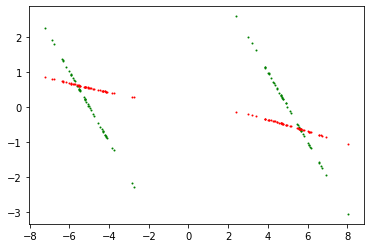

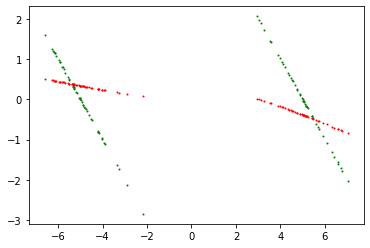

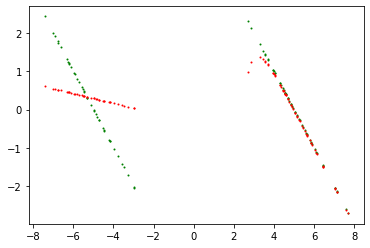

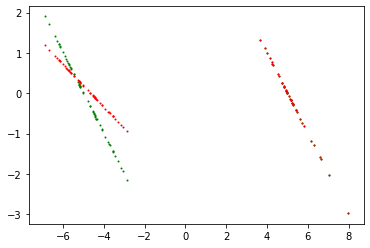

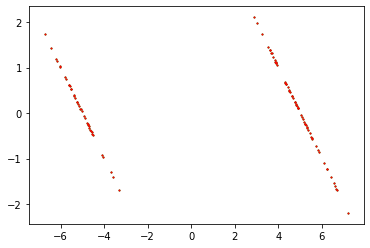

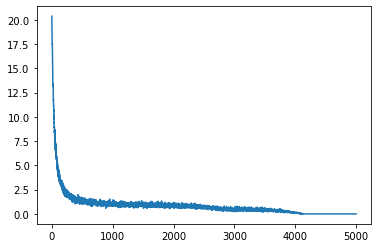

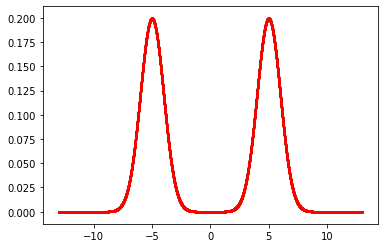

In [52]:
q_dis=mog()
loss_list=[]
for i in range(1,5001):
    q_dis.optimizer.zero_grad()
    x= gmm.sample([100]).requires_grad_()
    x_log_prob=torch.sum(gmm.log_prob(x))
    x_log_prob.backward(create_graph=False)
    x_gmm_score=x.grad.clone()
    x.grad.data.zero_()

    x_q_score=q_dis(x)

    if i%1000==0:
        plt.scatter(x.detach().numpy(),x_gmm_score.numpy(),alpha=1,s=1.,c='g')
        plt.scatter(x.detach().numpy(),x_q_score.detach().numpy(),alpha=1,s=1.,c='r')
        plt.show()

    loss= torch.mean((x_q_score-x_gmm_score)**2)
    loss.backward()
    q_dis.optimizer.step()
    loss_list.append(loss.item())

plt.plot(loss_list)
plt.show()
x_grid=torch.linspace(-13,13,10000)
y_pdf=torch.exp(gmm.log_prob(x_grid)).detach()
q_pdf_fisher=torch.exp(q_dis.log_prob(x_grid)).detach()


plt.scatter(x_grid,y_pdf,alpha=1,s=1.,c='g')
plt.scatter(x_grid,q_pdf_fisher,alpha=1,s=1.,c='r')
plt.show()





### Different initialization

In [ ]:
fisher_list=[]
init_list=[-10,-7.5,-5,-2.5,0,2.5,5,7.5,10]
for init in init_list:
    q_dis=gaussian(init)
    # q_dis=mog()
    loss_list=[]
    for i in range(1,5001):
        q_dis.optimizer.zero_grad()
        x= gmm.sample([100]).requires_grad_()
        x_log_prob=torch.sum(gmm.log_prob(x))
        x_log_prob.backward(create_graph=False)
        x_gmm_score=x.grad.clone()
        x.grad.data.zero_()

        x_q_score=q_dis(x)

#         if i%1000==0:
#             plt.scatter(x.detach().numpy(),x_gmm_score.numpy(),alpha=1,s=1.,c='g')
#             plt.scatter(x.detach().numpy(),x_q_score.detach().numpy(),alpha=1,s=1.,c='r')
#             plt.show()

        loss= torch.mean((x_q_score-x_gmm_score)**2)
        loss.backward()
        q_dis.optimizer.step()
        loss_list.append(loss.item())

    plt.plot(loss_list)
    plt.show()
    x_grid=torch.linspace(-13,13,10000)
    y_pdf=torch.exp(gmm.log_prob(x_grid)).detach()
    q_pdf_fisher=torch.exp(q_dis.log_prob(x_grid)).detach()


    plt.scatter(x_grid,y_pdf,alpha=1,s=1.,c='g')
    plt.scatter(x_grid,q_pdf_fisher,alpha=1,s=1.,c='r')
    plt.show()
    
    fisher_list.append(q_pdf_fisher)

# print('mu',q_dis.mu.item())
# print('std',torch.exp(q_dis.log_std).item())

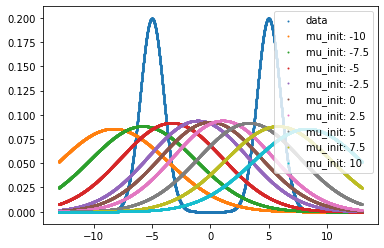

In [47]:
plt.scatter(x_grid,y_pdf,alpha=1,s=1.,label='data')
for index,fisher in enumerate(fisher_list):
    plt.scatter(x_grid,fisher_list[index],alpha=1,s=1.,label='mu_init: '+str(init_list[index]))

plt.legend()
plt.show()

For an under-powered model, fisher divergence may have a lot of local minimas.

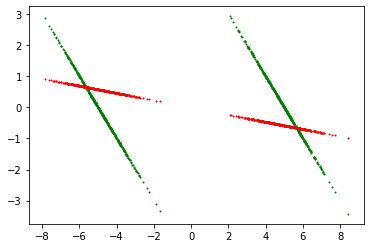

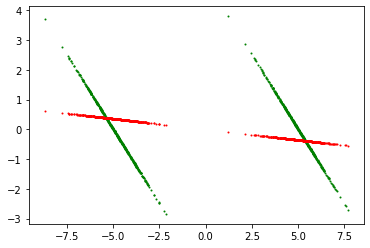

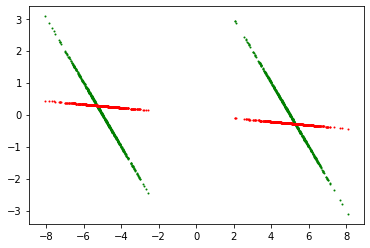

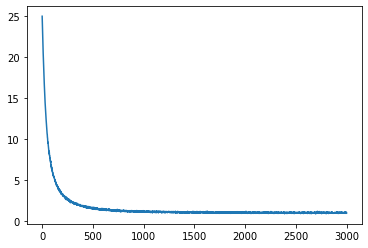

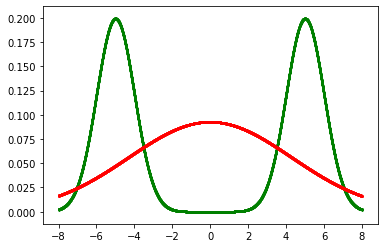

In [59]:
q_dis=gaussian(0.0)
# q_dis=mog()
loss_list=[]
for i in range(1,3001):
    q_dis.optimizer.zero_grad()
    x= gmm.sample([1000]).requires_grad_()
    x_log_prob=torch.sum(gmm.log_prob(x))
    x_log_prob.backward(create_graph=False)
    x_gmm_score=x.grad.clone()
    x.grad.data.zero_()
    
    x_q_score=q_dis(x)
    
    if i%1000==0:
        plt.scatter(x.detach().numpy(),x_gmm_score.numpy(),alpha=1,s=1.,c='g')
        plt.scatter(x.detach().numpy(),x_q_score.detach().numpy(),alpha=1,s=1.,c='r')
        plt.show()
    
    loss= torch.mean((x_q_score-x_gmm_score)**2)
    loss.backward()
    q_dis.optimizer.step()
    loss_list.append(loss.item())

plt.plot(loss_list)
plt.show()
x_grid=torch.linspace(-8,8,10000)
y_pdf=torch.exp(gmm.log_prob(x_grid)).detach()
q_pdf_fisher=torch.exp(q_dis.log_prob(x_grid)).detach()


plt.scatter(x_grid,y_pdf,alpha=1,s=1.,c='g')
plt.scatter(x_grid,q_pdf_fisher,alpha=1,s=1.,c='r')
plt.show()

# print('mu',q_dis.mu.item())
# print('std',torch.exp(q_dis.log_std).item())

### Forward KL

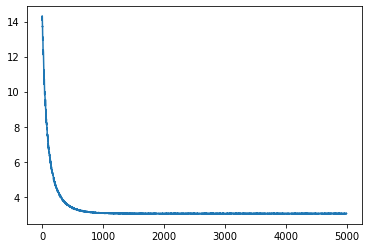

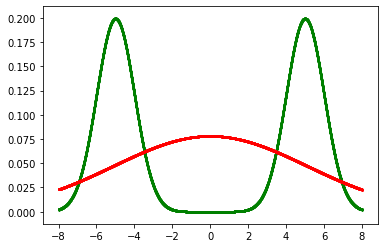

In [45]:
q_dis=gaussian(1.0)
# q_dis=mog()
loss_list=[]
for i in range(1,5001):
    q_dis.optimizer.zero_grad()
    x= gmm.sample([1000])
    loss=-torch.mean(q_dis.log_prob(x))
    
    
    loss.backward()
    q_dis.optimizer.step()
    loss_list.append(loss.item())

plt.plot(loss_list)
plt.show()
x_grid=torch.linspace(-8,8,10000)
y_pdf=torch.exp(gmm.log_prob(x_grid))
q_pdf_kl=torch.exp(q_dis.log_prob(x_grid)).detach()

plt.scatter(x_grid,y_pdf,alpha=1,s=1.,c='g')
plt.scatter(x_grid,q_pdf_kl,alpha=1,s=1.,c='r')
plt.show()

# print('mu',q_dis.mu.item())
# print('std',torch.exp(q_dis.log_std).item())

### Reverse KL

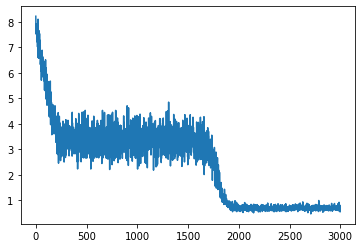

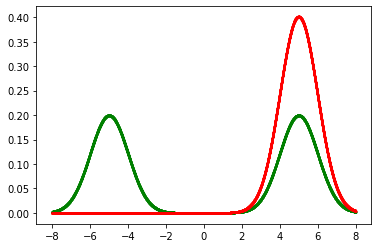

In [44]:
q_dis=gaussian(1.0)
loss_list=[]
for i in range(1,3001):
    q_dis.optimizer.zero_grad()
    x= q_dis.sample(100)
    loss=-q_dis.entropy()-torch.mean(gmm.log_prob(x))
    
    
    loss.backward()
    q_dis.optimizer.step()
    loss_list.append(loss.item())

plt.plot(loss_list)
plt.show()
x_grid=torch.linspace(-8,8,10000)
y_pdf=torch.exp(gmm.log_prob(x_grid))
q_pdf_rkl=torch.exp(q_dis.log_prob(x_grid)).detach()

plt.scatter(x_grid,y_pdf,alpha=1,s=1.,c='g')
plt.scatter(x_grid,q_pdf_rkl,alpha=1,s=1.,c='r')
plt.show()

# print('mu',q_dis.mu.item())
# print('std',torch.exp(q_dis.log_std).item())

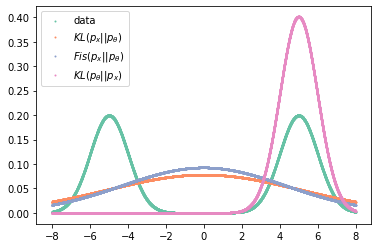

In [60]:
import seaborn as sns
palette= sns.color_palette("Set2").as_hex()

# print(palette)

plt.scatter(x_grid,y_pdf,alpha=1,s=1.,c=palette[0],label='data')
plt.scatter(x_grid,q_pdf_kl,alpha=1,s=1.,c=palette[1],label='$KL(p_x||p_{\\theta})$')
plt.scatter(x_grid,q_pdf_fisher,alpha=1,s=1.,c=palette[2],label='$Fis(p_x||p_{\\theta})$')
plt.scatter(x_grid,q_pdf_rkl,alpha=1,s=1.,c=palette[3],label='$KL(p_\\theta||p_x)$')

plt.legend()
plt.show()

Even with a good initialization, the model learned by fisher divergence has lighter tails than the model learned by forward KL